In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import vr2p
import pandas as pd
from tqdm.notebook import tqdm
from vr2p import styles
from vr2p.gimbl.extract import movement_speed
from matplotlib.ticker import MaxNLocator

plt.style.use(styles('publication-tight'))

# General parameters

In [2]:
# Parameters
animals = ['A4','A5','A7','B2','B3','B4','B5','C1','D1','F1', 'F5']

period_number = 3
speed_window_size_ms = 500
speed_ignore_threshold = 1000
spatial_bin_size = 10
time_range=[0,40] # session time window to break into periods (in minutes)

# Collect data

In [3]:
# go through animals
result = []
for animal in tqdm(animals):
    # get animal data
    data = vr2p.ExperimentData(f'gs://linear-2ac/Set A/Tyche-{animal}-SetA.zarr')
    # store for heatmaps
    near_heatmap = []
    far_heatmap  = []
    # go through sessions.
    num_sessions = len(data.vr)
    for session in range(num_sessions):
        vr = data.vr[session]
        trial = vr.trial.copy()
        position = vr.path.time
        # remove position info outside of trials (avoids including freezed frames).
        position =position[position['trial_number'].isnull()==False].copy()
        # add period info.
        trial['session_period'] = None
        delta_time = (time_range[1]-time_range[0])/period_number
        time_start = time_range[0]
        for i in range(period_number):
            trial.loc[trial.time_start.between(pd.Timedelta(time_start,'min'),pd.Timedelta(time_start+delta_time,'min')),'session_period'] = i
            time_start+=delta_time
        # Get speed.
        position['speed'] = movement_speed(position,
                        window_size=speed_window_size_ms,ignore_threshold=speed_ignore_threshold)
        # add spatial bin info
        spatial_bins = np.arange(0,230+spatial_bin_size,spatial_bin_size)
        position['bin'] = pd.cut(position['position'],spatial_bins,labels = np.arange(0,spatial_bins.shape[0]-1),include_lowest=True)
        # group by bin and trial_number and get mean speed
        binned_speed = position.groupby(['bin','trial_number']).mean().reset_index()[['bin','trial_number','speed']]    # fill in heatmap
        # collect heatmaps
        for reward_id in [1,2]:
            for session_period in range(period_number):
                selected_trials = trial.loc[(trial.session_period==session_period)&(trial.reward_id==reward_id),'trial_number']
                period_speed = binned_speed.loc[binned_speed.trial_number.isin(selected_trials)]
                period_speed = period_speed.groupby('bin').mean().reset_index()
                # fill in values.
                temp = np.zeros(spatial_bins.shape[0]-1)
                temp[period_speed['bin']]=period_speed['speed']
                if reward_id==1:
                    near_heatmap.append(temp)
                else:
                    far_heatmap.append(temp)
    # collect data
    result.append({'animal':animal,'num_sessions':num_sessions,
                   'near':np.array(near_heatmap),'far':np.array(far_heatmap)})
result = pd.DataFrame(result).set_index('animal')

  0%|          | 0/11 [00:00<?, ?it/s]

In [4]:
display(result)

,num_sessions,near,far
animal,,,
A4,10,"[[6.427817422451424, 14.140354977521756, 16.57...","[[3.813276381848817, 12.414458609197924, 16.29..."
A5,6,"[[10.78789722298897, 15.572391292024543, 18.75...","[[15.208722415483598, 15.039308145634259, 16.8..."
A7,9,"[[10.761307009958335, 14.507633242037569, 16.9...","[[12.574772882965819, 14.200048525127217, 15.7..."
B2,7,"[[13.654327966628115, 11.734908620545815, 14.6...","[[13.001286835666434, 14.317883104876683, 16.8..."
B3,15,"[[5.001554869583699, 9.995188890449564, 12.675...","[[7.010200666413758, 13.062291096471135, 13.41..."
B4,5,"[[15.350421305898557, 18.206063084734282, 21.7...","[[13.215611030277607, 18.919770251430183, 19.0..."
B5,7,"[[19.633089831398856, 14.906916293592843, 18.4...","[[17.407312116726995, 13.12713657034292, 15.30..."
C1,13,"[[1.4849284284111555, 7.7923986043425515, 3.63...","[[1.4279061232475438, 7.002361311422078, 6.026..."
D1,13,"[[17.5301180023213, 14.248921783226908, 16.277...","[[14.893816264111187, 14.429956051938959, 16.1..."


# plot (single animal)

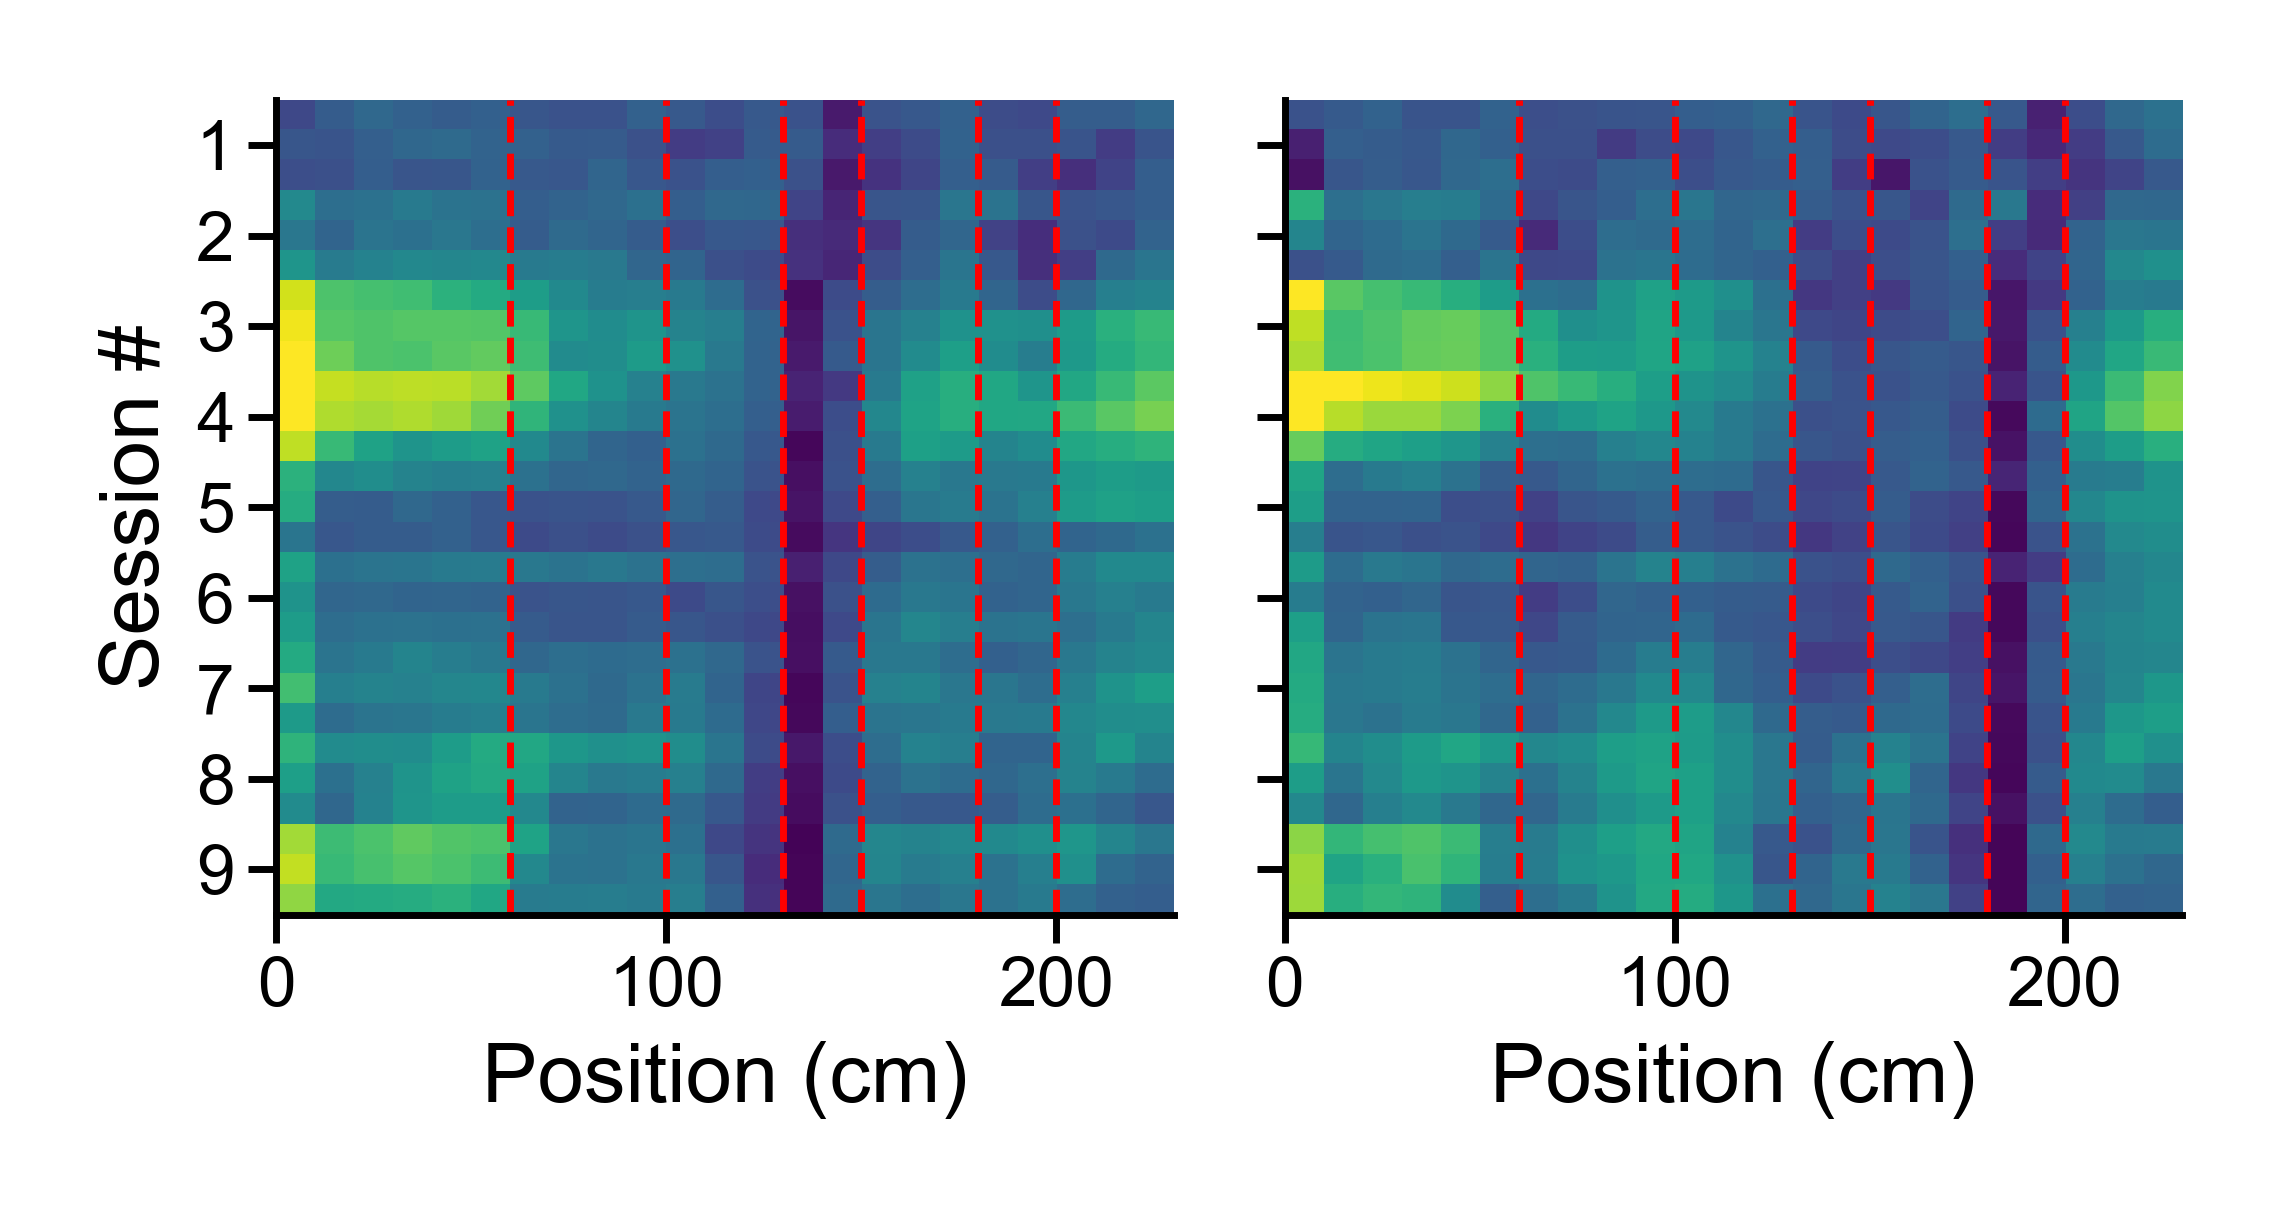

In [11]:
def plot_speed_heatmap(ax_near, ax_far, animal):
    ax_near.set_ylabel('Session #')
    ax_far.set_yticklabels([])
    axs ={'near':ax_near,'far':ax_far}
    for key in ['near','far']:
        ax = axs[key]
        ax.set_xlabel('Position (cm)')
        ax.set_xlim(0,230)

        # plot heatmap.
        c_result = np.flipud(result.loc[animal,key])
        im = ax.imshow(c_result,cmap='viridis',vmin=0,vmax=50,extent = [0,230,0.5,result.loc[animal,'num_sessions']+0.5],aspect='auto')   
        # plot reward pos
        for line in [130,150,180,200]:
            ax.axvline(line,color='red',linestyle='--',marker='')
        for line in [60,100]:
            ax.axvline(line,color='red',linestyle='--',marker='',linewidth=0.5)
        # plot session lines
        session_lines = np.arange(period_number, c_result.shape[1],period_number)
        #ax.axhline(session_lines,color='black',linestyle='--',marker='',alpha=0.5)   
        # invert y axis
        ax.invert_yaxis()     
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))


plt.style.use(styles('publication-tight'))
# plot
axs = plt.figure(figsize=(55/25.4 ,28/25.4),dpi=1000,layout="constrained").subplot_mosaic(
    [
        ['near','far'],
    ],
    empty_sentinel="BLANK",
    # set the height ratios between the rows
    height_ratios=[1,],
    # set the width ratios between the columns
    width_ratios=[1,1],
)
plot_speed_heatmap(axs['near'],axs['far'], animals[2])

# plot all

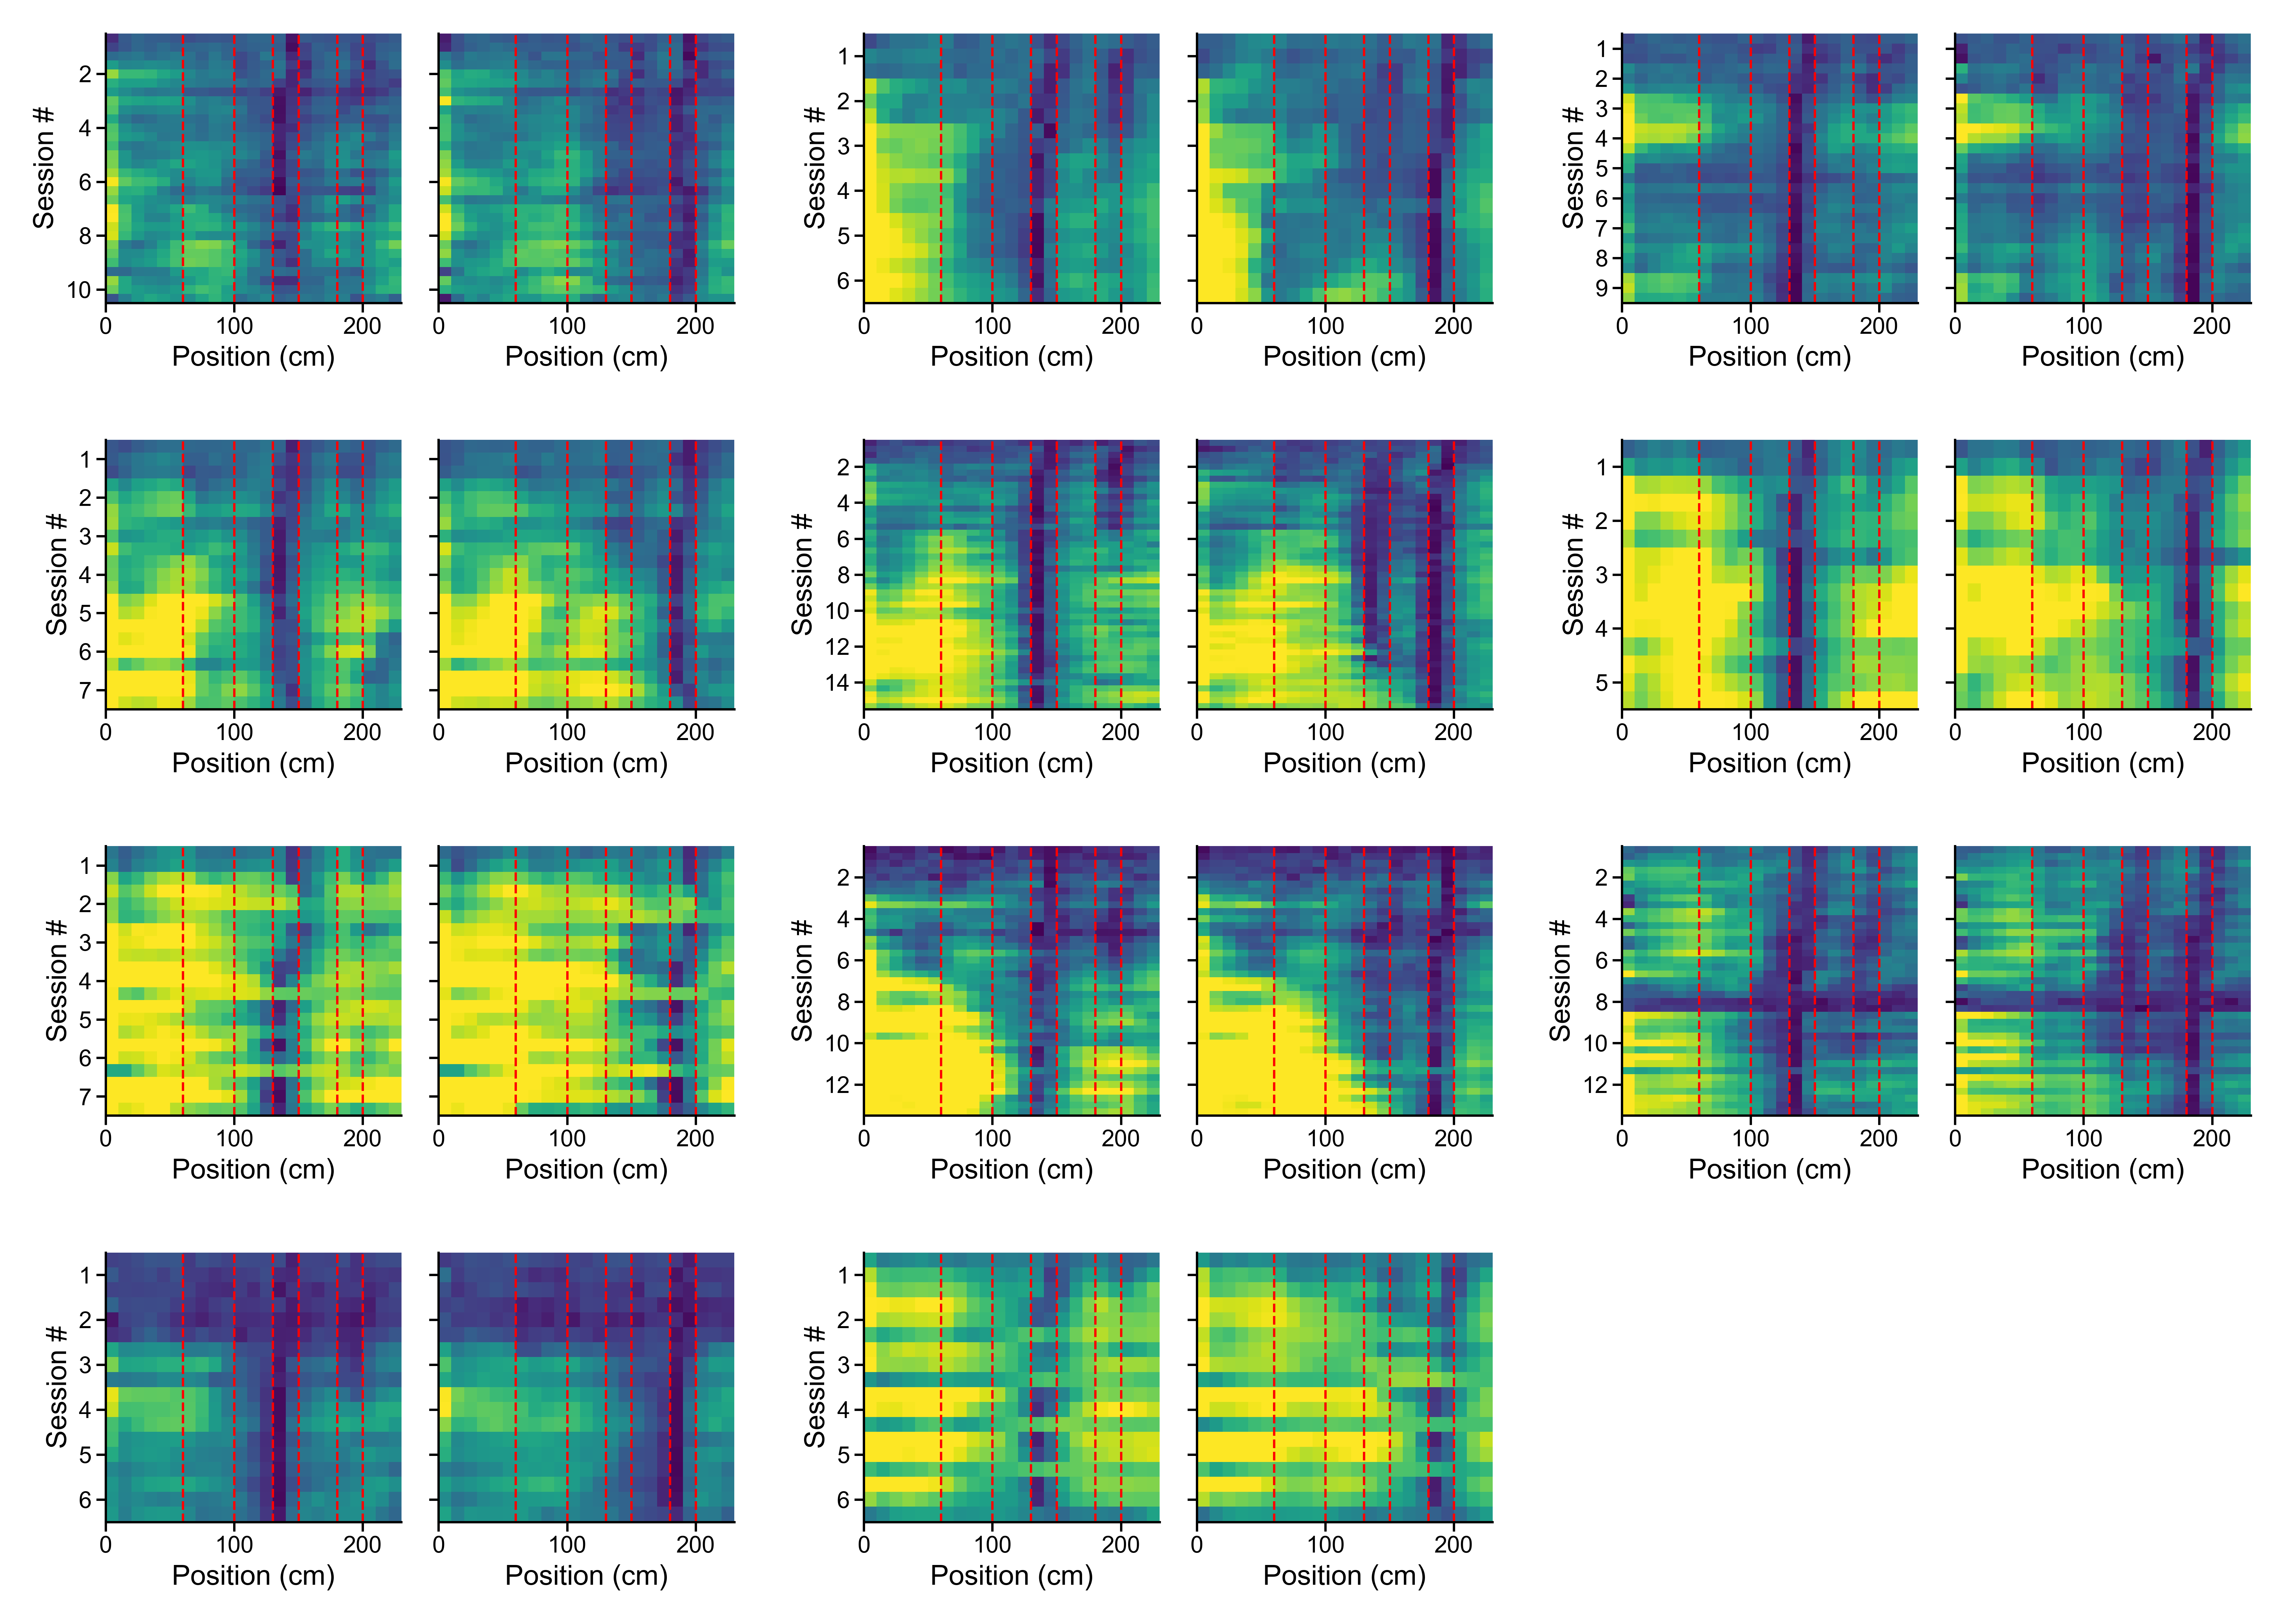

In [12]:
plt.style.use(styles('publication-tight'))
# plot
axs = plt.figure(figsize=(170/25.4 ,120/25.4),dpi=1000,layout="constrained").subplot_mosaic(
    [
        ['A4_near','A4_far','BLANK',   'A5_near','A5_far','BLANK',     'A7_near','A7_far'],
        ['BLANK' for i in range(8)],
        ['B2_near','B2_far','BLANK',   'B3_near','B3_far','BLANK',     'B4_near','B4_far'],
        ['BLANK' for i in range(8)],        
        ['B5_near','B5_far','BLANK',   'C1_near','C1_far','BLANK',     'D1_near','D1_far'],        
        ['BLANK' for i in range(8)],        
        ['F1_near','F1_far','BLANK',   'F5_near','F5_far','BLANK',     'BLANK','BLANK'],               
    ],
    empty_sentinel="BLANK",
    # set the height ratios between the rows
    height_ratios=[1,0.15,  1,0.15,  1,0.15,  1],
    # set the width ratios between the columns
    width_ratios=[1,1,0.1,  1,1,0.1,   1,1],
)
for animal in animals:
    plot_speed_heatmap(axs[f'{animal}_near'],axs[f'{animal}_far'], animal)